In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd 'drive/My Drive/CSE842 Project/SemEval2018-Task1-all-data/SemEval2018-Task1-all-data/English/E-c'

[Errno 2] No such file or directory: 'drive/My Drive/CSE842 Project/SemEval2018-Task1-all-data/SemEval2018-Task1-all-data/English/E-c'
/content/drive/My Drive/CSE842 Project/SemEval2018-Task1-all-data/SemEval2018-Task1-all-data/English/E-c


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import re
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, jaccard_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

In [ ]:
df = pd.read_csv('2018-E-c-En-train.txt', sep='\t', on_bad_lines='skip')
df = df.drop(columns=['ID'])
df

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6833,@nicky57672 Hi! We are working towards your hi...,0,0,0,0,0,0,0,0,0,0,0
6834,@andreamitchell said @berniesanders not only d...,0,1,0,0,0,0,0,0,0,1,0
6835,@isthataspider @dhodgs i will fight this guy! ...,1,0,1,0,0,0,0,1,0,0,0
6836,i wonder how a guy can broke his penis while h...,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
def checkTweet(text, token):
    num = 0
    for word in text.split():
        if re.search(token, word):
            num += 1
    return num

In [ ]:
df['hashtag'] = df['Tweet'].apply(lambda x: checkTweet(x, '^#'))
df['mention'] = df['Tweet'].apply(lambda x: checkTweet(x, '^@'))
df['url'] = df['Tweet'].apply(lambda x: checkTweet(x, '^http'))

print(f"Total # of hashtags: {np.sum(df['hashtag'])}")
print(f"Total # of mentions: {np.sum(df['mention'])}")
print(f"Total # of urls: {np.sum(df['url'])}")
df

Total # of hashtags: 7016
Total # of mentions: 4236
Total # of urls: 0


,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,hashtag,mention,url
0,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1,3,0,0
1,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0,1,0,0
2,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0,1,1,0
3,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6833,@nicky57672 Hi! We are working towards your hi...,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6834,@andreamitchell said @berniesanders not only d...,0,1,0,0,0,0,0,0,0,1,0,0,2,0
6835,@isthataspider @dhodgs i will fight this guy! ...,1,0,1,0,0,0,0,1,0,0,0,0,2,0
6836,i wonder how a guy can broke his penis while h...,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
def preprocess_with_spacy(text):
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove hashtags
    text = re.sub(r'#\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\S+', '', text)
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_punct and not token.is_space]
    tokens = [token if token != '.' else ' ' for token in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

In [ ]:
df['Tweet'] = df['Tweet'].apply(preprocess_with_spacy)
df

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,hashtag,mention,url
0,worry is a down payment on a problem you may n...,0,1,0,0,0,0,1,0,0,0,1,3,0,0
1,whatever you decide to do make sure it makes you,0,0,0,0,1,1,1,0,0,0,0,1,0,0
2,it also helps that the majority of nfl coachin...,1,0,1,0,1,0,1,0,0,0,0,1,1,0
3,accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,my roommate it 's okay that we ca n't spell be...,1,0,1,0,0,0,0,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6833,hi we are working towards your highlighted con...,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6834,said not only did not play up hrc in campaigni...,0,1,0,0,0,0,0,0,0,1,0,0,2,0
6835,i will fight this guy do n't insult the lions ...,1,0,1,0,0,0,0,1,0,0,0,0,2,0
6836,i wonder how a guy can broke his penis while h...,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [ ]:
tweets = df['Tweet']
new_fearutes = np.column_stack((df['hashtag'], df['mention']))
new_fearutes = csr_matrix(new_fearutes)
count_vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X = count_vectorizer.fit_transform(tweets)
Y = df.drop(columns=['Tweet', 'hashtag', 'mention', 'url'])
X_new = hstack((X, new_fearutes))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.2, random_state=42)

In [ ]:
X_train = csr_matrix(X_train)
X_test = csr_matrix(X_test)

X_train = X_train.toarray()
X_test = X_test.toarray()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

print(X_train_tensor.shape)
print(X_test_tensor.shape)
print(y_train.shape)

torch.Size([5470, 49436])
torch.Size([1368, 49436])
(5470, 11)


In [ ]:
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

print(y_train_tensor.shape)

torch.Size([5470, 11])


In [ ]:
df2 = pd.read_csv('2018-E-c-En-test-gold.txt', sep='\t', on_bad_lines='skip')
df2 = df2.drop(columns=['ID'])
df2

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,1,1,0,0,0,0,1,0,0,0,1
1,"Academy of Sciences, eschews the normally sobe...",0,0,1,0,0,0,0,0,0,0,0
2,I blew that opportunity -__- #mad,1,0,1,0,0,0,0,0,1,0,0
3,This time in 2 weeks I will be 30... 😥,0,0,0,0,1,0,0,0,1,0,0
4,#Deppression is real. Partners w/ #depressed p...,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3254,shaft abrasions from panties merely shifted to...,1,0,0,0,0,0,0,1,0,0,0
3255,@lomadia heard of Remothered? Indie horror gam...,0,1,0,0,0,0,0,1,0,0,0
3256,All this fake outrage. Y'all need to stop 🤣,1,0,1,0,0,0,0,0,0,0,0
3257,Would be ever so grateful if you could record ...,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
df2['hashtag'] = df2['Tweet'].apply(lambda x: checkTweet(x, '^#'))
df2['mention'] = df2['Tweet'].apply(lambda x: checkTweet(x, '^@'))
df2['url'] = df2['Tweet'].apply(lambda x: checkTweet(x, '^http'))
df2

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,hashtag,mention,url
0,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,1,1,0,0,0,0,1,0,0,0,1,0,2,0
1,"Academy of Sciences, eschews the normally sobe...",0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,I blew that opportunity -__- #mad,1,0,1,0,0,0,0,0,1,0,0,1,0,0
3,This time in 2 weeks I will be 30... 😥,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,#Deppression is real. Partners w/ #depressed p...,0,0,0,1,0,0,0,0,1,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,shaft abrasions from panties merely shifted to...,1,0,0,0,0,0,0,1,0,0,0,2,0,0
3255,@lomadia heard of Remothered? Indie horror gam...,0,1,0,0,0,0,0,1,0,0,0,0,1,0
3256,All this fake outrage. Y'all need to stop 🤣,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3257,Would be ever so grateful if you could record ...,0,0,0,0,1,0,0,0,0,0,0,1,2,0


In [ ]:
df2['Tweet'] = df2['Tweet'].apply(preprocess_with_spacy)

In [ ]:
tweets = df2['Tweet']
X_gold = count_vectorizer.transform(tweets)
y_gold = df2.drop(columns=['Tweet', 'hashtag', 'mention', 'url'])

new_fearutes2 = np.column_stack((df2['hashtag'], df2['mention']))
new_fearutes2 = csr_matrix(new_fearutes2)
X_gold_new = hstack((X_gold, new_fearutes2))

print(X_gold.shape)
print(X_gold_new.shape)
print(y_gold.shape)
df2['mention'].isna().sum()

(3259, 49434)
(3259, 49436)
(3259, 11)


0

In [ ]:
X_test_gold = csr_matrix(X_gold_new).toarray()
X_gold_tensor = torch.tensor(X_test_gold, dtype=torch.float32)

y_gold_tensor = torch.tensor(y_gold.to_numpy(), dtype=torch.float32)

In [ ]:
def MultiLabelAccuracy(pred_vals, real_vals):
    ML_accur = 0
    for row1, row2 in zip(pred_vals, real_vals):
        if len(row1) != len(row2):
            print("Rows are not the same length:")
            print(row1)
            print(row2)
        num_correct = 0
        for i in range(len(row1)):
            if row1[i] == row2[i]:
                num_correct += 1

        intersection_size = num_correct
        union_size = len(row1) + len(row2) - num_correct
        row_accur = intersection_size / union_size
        ML_accur += row_accur
        # print(intersection_size)
        # print(union_size)
    # print(len(pred_vals))
    # print(ML_accur)
    return ML_accur / len(pred_vals)

In [ ]:
def MacroF1(pred_vals, real_vals):
    num_classes = len(pred_vals[0])
    correct = [0] * num_classes
    num_assigned = [0] * num_classes
    num_in_class = [0] * num_classes
    for row1, row2 in zip(pred_vals, real_vals):
        for i in range(num_classes):
            if row1[i] == 1:
                if row1[i] == row2[i]:
                    correct[i] += 1
                    num_assigned[i] += 1
                else:
                    num_assigned[i] += 1
            if row2[i] == 1:
                num_in_class[i] += 1
    macroF1 = 0
    for i in range(num_classes):
        if num_assigned[i] == 0:
            precision = 0
        else:
            precision = correct[i] / num_assigned[i]
        if num_in_class[i] == 0:
            recall = 0
        else:
            recall = correct[i] / num_in_class[i]
        if precision + recall == 0:
            F = 0
        else:
            F = (2 * precision * recall) / (precision + recall)
        macroF1 += F
    return macroF1 / num_classes

In [ ]:
class MultiLabelClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MultiLabelClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [ ]:
# define the input and output sizes based on data
input_size = X_train_tensor.shape[1]
hidden_size = 50
num_classes = y_train_tensor.shape[1]

# instantiate the model
model = MultiLabelClassificationModel(input_size, hidden_size, num_classes)

print(input_size)
print(num_classes)

49436
11


In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
num_epochs = 100

loss_history = []

for epoch in tqdm(range(num_epochs), desc='Training Progress'):

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    loss_history.append(loss.item())

print('Training complete')

Training Progress: 100%|██████████| 100/100 [02:34<00:00,  1.55s/it]

Training complete


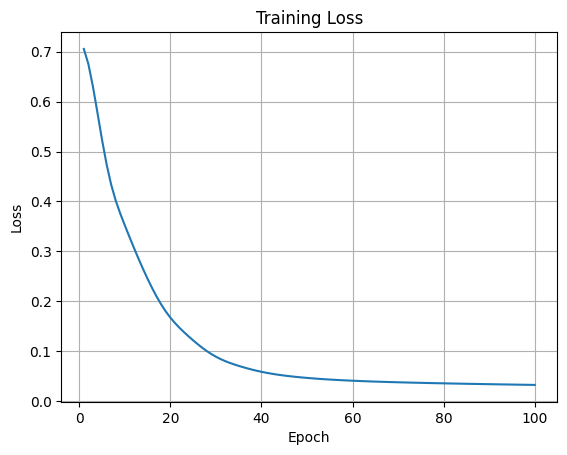

In [ ]:
plt.plot(range(1, num_epochs + 1), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

In [ ]:
model.eval()

num_correct = 0
num_samples = 0

with torch.no_grad():
    y_pred = model(X_test_tensor)
    predicted = (y_pred > 0.5).float()

    num_correct += (predicted == y_test_tensor).sum().item()
    num_samples += y_test_tensor.numel()

accuracy = num_correct / num_samples
print(f'Accuracy on the test set: {accuracy * 100:.2f}%')
MLA = MultiLabelAccuracy(predicted, y_test_tensor)
print("Multi-label Accuracy on test set: ", MLA)

Accuracy on the test set: 80.07%
Multi-label Accuracy on test set:  0.6846572091795792


In [ ]:
model.eval()

num_correct = 0
num_samples = 0
test_accur = 0

with torch.no_grad():
    y_pred_gold = model(X_gold_tensor)
    predicted = (y_pred_gold > 0.5).float()
    print(y_gold_tensor.shape)
    print(predicted.shape)
    num_correct += (predicted == y_gold_tensor).sum().item()
    num_samples += y_gold_tensor.numel()

    test_accur += num_correct / 11

accuracy = num_correct / num_samples
print(f'Accuracy on the test set: {accuracy * 100:.2f}%')
test_accur = test_accur / num_samples
print(f'Accuracy on the test set: {test_accur * 100:.2f}%')
print(MultiLabelAccuracy(predicted, y_gold_tensor))
report = classification_report(y_gold_tensor, predicted, output_dict=True)
print("Classification Report for Neural Network (Test Set): \n", classification_report(y_gold_tensor, predicted))

torch.Size([3259, 11])
torch.Size([3259, 11])
Accuracy on the test set: 78.66%
Accuracy on the test set: 7.15%
0.6638691594370864
Classification Report for Neural Network (Test Set): 
               precision    recall  f1-score   support

           0       0.51      0.29      0.37      1101
           1       0.34      0.03      0.05       425
           2       0.48      0.29      0.37      1099
           3       0.35      0.07      0.12       485
           4       0.70      0.29      0.41      1442
           5       0.66      0.13      0.22       516
           6       0.61      0.20      0.30      1143
           7       0.16      0.02      0.03       375
           8       0.43      0.17      0.24       960
           9       0.33      0.01      0.01       170
          10       0.07      0.01      0.01       153

   micro avg       0.54      0.20      0.29      7869
   macro avg       0.42      0.14      0.19      7869
weighted avg       0.51      0.20      0.28      7869
 sa

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, class_weight="balanced_subsample", random_state=42)

rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', random_state=42)

In [ ]:
rf_y_pred = rf_classifier.predict(X_test)

In [ ]:
rf_MLA = MultiLabelAccuracy(rf_y_pred, y_test.to_numpy())
print(rf_MLA)
rf_report = classification_report(y_test, rf_y_pred, output_dict=True)
print("Classification Report for Random Forest (Test Set): \n", classification_report(y_test, rf_y_pred))

0.6543621887497529
Classification Report for Random Forest (Test Set): 
               precision    recall  f1-score   support

           0       0.56      0.32      0.41       507
           1       0.32      0.05      0.09       200
           2       0.52      0.46      0.49       516
           3       0.45      0.19      0.27       283
           4       0.66      0.25      0.37       507
           5       0.37      0.16      0.22       136
           6       0.56      0.21      0.31       400
           7       0.19      0.15      0.17       166
           8       0.42      0.33      0.37       424
           9       0.23      0.04      0.07        76
          10       0.39      0.10      0.16        71

   micro avg       0.49      0.27      0.34      3286
   macro avg       0.43      0.21      0.27      3286
weighted avg       0.49      0.27      0.33      3286
 samples avg       0.35      0.27      0.28      3286



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
rf_y_pred_gold = rf_classifier.predict(X_test_gold)

In [ ]:
rf_MLA_gold = MultiLabelAccuracy(rf_y_pred_gold, y_gold.to_numpy())
print(rf_MLA_gold)
macroF1 = MacroF1(rf_y_pred_gold, y_gold.to_numpy())
print(macroF1)
print("jaccard_score: ", jaccard_score(y_gold.to_numpy(), rf_y_pred_gold, average="samples"))
print("Classification Report for Random Forest (Gold Set): \n", classification_report(y_gold, rf_y_pred_gold))

0.6286531725313804
0.17185071336145188
jaccard_score:  0.1595946755504902
Classification Report for Random Forest (Gold Set): 
               precision    recall  f1-score   support

           0       0.44      0.18      0.25      1101
           1       0.00      0.00      0.00       425
           2       0.41      0.33      0.37      1099
           3       0.18      0.10      0.13       485
           4       0.60      0.21      0.31      1442
           5       0.38      0.12      0.18       516
           6       0.44      0.13      0.20      1143
           7       0.15      0.11      0.13       375
           8       0.36      0.27      0.31       960
           9       0.33      0.01      0.01       170
          10       0.00      0.00      0.00       153

   micro avg       0.39      0.18      0.25      7869
   macro avg       0.30      0.13      0.17      7869
weighted avg       0.39      0.18      0.24      7869
 samples avg       0.27      0.18      0.20      7869



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


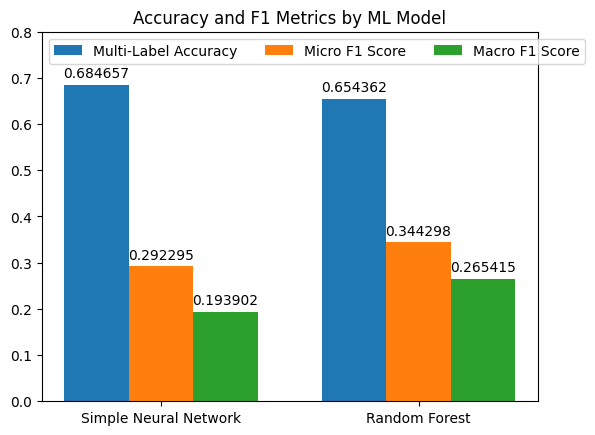

In [ ]:
models = ["Simple Neural Network", "Random Forest"]

graph_data = {
    'Multi-Label Accuracy': (MLA, rf_MLA),
    'Micro F1 Score':(report['micro avg']['f1-score'], rf_report['micro avg']['f1-score']),
    'Macro F1 Score': (report['macro avg']['f1-score'], rf_report['macro avg']['f1-score']),
}

fig, ax = plt.subplots()

x = np.arange(len(models))
width = .25
multiplier = 0

for attribute, measurement in graph_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_title('Accuracy and F1 Metrics by ML Model')
ax.set_xticks(x + width, models)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, .8)

plt.show()